# Customer Segmentation using NLP and BDScan on Apparel Reviews

### Problem Statement 

"Apparel and accessories represented 29% of Amazon’s retail e-commerce sales in the U.S. last year, generating $35.79 billion, according to research firm eMarketer." (Lee, 2019)

Amazon is looking to expand it's share of the fashion business. Amazon Fashion recently begun a series of limited-edition influencer-designed collections called The Drop. The collections drop every Thursday and are available for purchase for only 30 hours, making the pieces extra exclusive. In even simplier ways, on the Amazon Fashion home page, they highlighting links to lists of items that have over a certain threshold of reviewers as, 'Customer's most loved styles'. Once you navigate to that page, they've even taken this up a step further with different product categories and influencer's reviews of popular products. Later this month, Amazon Prime is releasing "Making The Cut" a fashion-based reality TV show with Heidi Klum and Tim Gunn, of Project Runway fame. The premise of the show is designers will compete to launch an new brand and a 1 million dollar prize. The winning designs will then be available to shop on Amazon Fashion immediately afterwards. 

Working with data made available from researchers at UCSD, we will process the text of reviews using NLP techniques and then use unsupervised learning techniques to make clusters. The model will be evaluated on it's Silhouette Score.  From there we'll do EDA on these different clusters to figure out which segementation of the market they are and provide insights on how they should be targeted.

### Data Dictionary 

|Feature|Type|Description|
|---|---|---|
|reviewerID|Object|ID of the reviewer.|
|asin|Object| ID of the product.|
|reviewerName| Object| name of the reviewer.|
|vote| Object| helpfulness votes of the review| 
|style| Integer|  a dictionary of the product metadata.|
|reviewText| Object |text of the review|
|overall| Integer | rating of the product|
|summary |Object |summary of the review |
|unixReviewTime |Integer| time of the review (unix time) |
|reviewTime| | time of the review (raw)|
|image|| image that users post after they have recieved the product|



### Importing packages

In [34]:
import os
import json
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno 
from urllib.request import urlopen


## Importing Data 

The data is broken into 2 datasets, the first which we'll spend the majority of our time working with is the reviews dataset with a total of 883,636 rows. We'll also load and clean the metadata, which has more information about the products being reviewed. 

In [15]:
# reading in Amazon Fashion review data 
data = []
with gzip.open('./AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])


883636
{'overall': 5.0, 'verified': True, 'reviewTime': '10 20, 2014', 'reviewerID': 'A1D4G1SNUZWQOT', 'asin': '7106116521', 'reviewerName': 'Tracy', 'reviewText': 'Exactly what I needed.', 'summary': 'perfect replacements!!', 'unixReviewTime': 1413763200}


In [27]:
# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)

print(len(df))

883636


In [71]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN


In [73]:
df.shape

(883636, 12)

In [40]:
# reading in Metadata, which contains the product information 
# this dataset includes a notebook which walks you through additional data cleaning, this is pulled from that 
# https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=LgWrDtZ94w89
asin_data = []
with gzip.open('./meta_AMAZON_FASHION.json.gz') as f:
    for l in f:
        asin_data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(asin_data))

# first row of the list
print(asin_data[0])

186637
{'title': 'Slime Time Fall Fest [With CDROM and Collector Cards and Neutron Balls, Incredi-Ball and Glow Stick Necklace, Paper Fram', 'image': ['https://images-na.ssl-images-amazon.com/images/I/51bSrINiWpL._US40_.jpg'], 'brand': 'Group Publishing (CO)', 'feature': ['Product Dimensions:\n                    \n8.7 x 3.6 x 11.4 inches', 'Shipping Weight:\n                    \n2.4 pounds'], 'rank': '13,052,976inClothing,Shoesamp;Jewelry(', 'date': '8.70 inches', 'asin': '0764443682'}


In [68]:
asin_df = pd.DataFrame.from_dict(asin_data)
print(len(asin_df))

186637


In [69]:
# this dataset includes a notebook which walks you through additional data cleaning,
# https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=LgWrDtZ94w89
# remove rows with unformatted title (i.e. some 'title' may still contain html style content)
df3 = asin_df.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
product_df = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
print(len(df4))
print(len(product_df))

430
186207


In [70]:
product_df.head()

,title,image,brand,feature,rank,date,asin,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,[https://images-na.ssl-images-amazon.com/image...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,,,,,,,,
1,XCC Qi promise new spider snake preparing men'...,[https://images-na.ssl-images-amazon.com/image...,,,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,,,,,,,,
2,Magical Things I Really Do Do Too!,[https://images-na.ssl-images-amazon.com/image...,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[For the professional or amateur magician. Ro...,,,,,,,
3,"Ashes to Ashes, Oranges to Oranges",[https://images-na.ssl-images-amazon.com/image...,Flickerlamp Publishing,[Package Dimensions:\n \n8....,"19,734,184inClothing,ShoesJewelry(",5 star,1940735033,,,,,,,,
4,Aether & Empire #1 - 2016 First Printing Comic...,[https://images-na.ssl-images-amazon.com/image...,,[Package Dimensions:\n \n10...,"10,558,646inClothing,Shoesamp;Jewelry(",5 star,1940967805,,$4.50,,,,,,


In [72]:
product_df.shape

(186207, 15)

## Initial EDA and Cleaning

In [30]:
#Initial data checks 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         883636 non-null  float64
 1   verified        883636 non-null  bool   
 2   reviewTime      883636 non-null  object 
 3   reviewerID      883636 non-null  object 
 4   asin            883636 non-null  object 
 5   reviewerName    883544 non-null  object 
 6   reviewText      882403 non-null  object 
 7   summary         883103 non-null  object 
 8   unixReviewTime  883636 non-null  int64  
 9   vote            79900 non-null   object 
 10  style           304569 non-null  object 
 11  image           28807 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 75.0+ MB


In [31]:
#Initial data checks 
df.describe()

,overall,unixReviewTime
count,883636.00000,8.836360e+05
mean,3.90694,1.456751e+09
std,1.41828,4.430691e+07
min,1.00000,1.036973e+09
25%,3.00000,1.434240e+09
50%,5.00000,1.462234e+09
75%,5.00000,1.484266e+09
max,5.00000,1.538352e+09


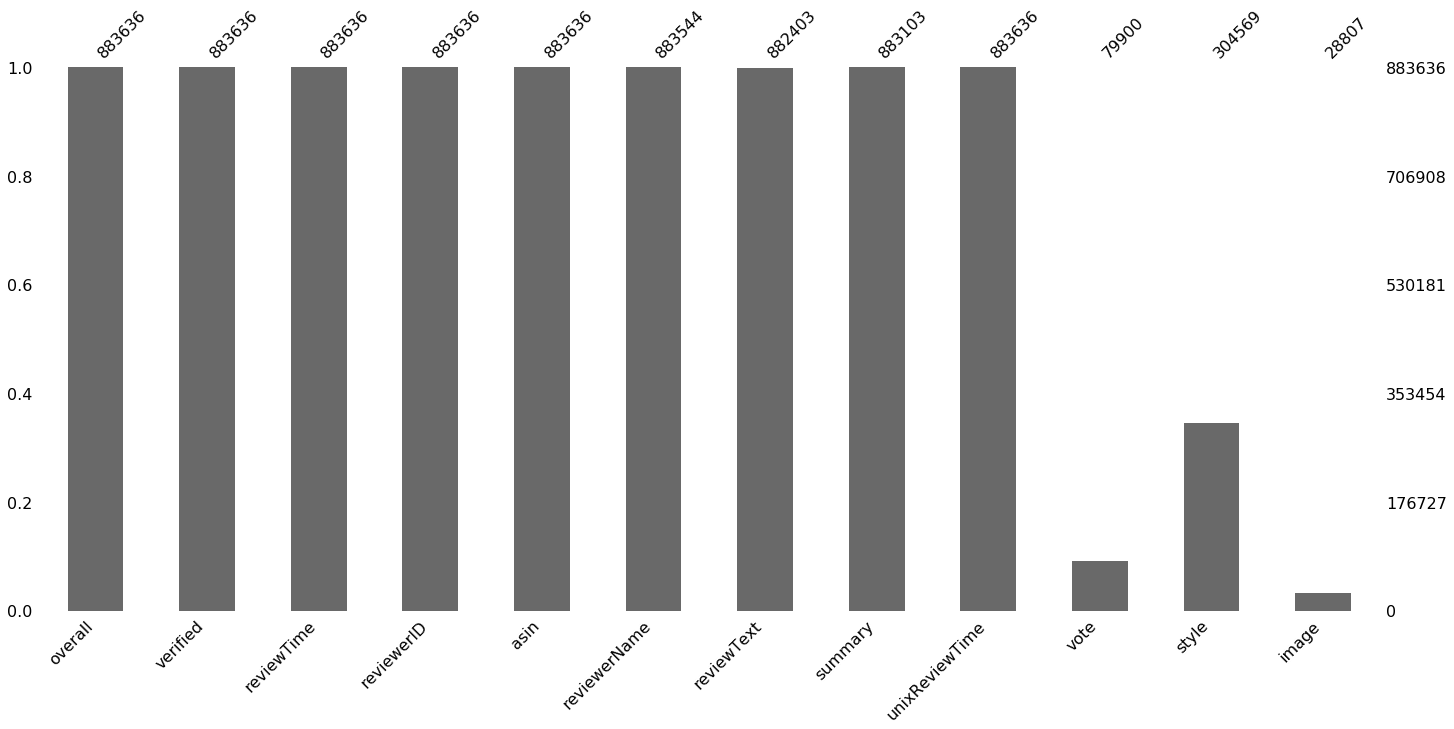

In [32]:
#plot nulls quickly 
msno.bar(df) 

**Oberservation:** There appears to be missing data in the `reviewerName` column, since this seems to be a duplicate of the `reveiwerID` column I'll drop it.  

### Initial EDA

In [24]:
df['reviewerID'].value_counts()

A3G5KDMFNRUXHB    40
A3JBQHQZEZPQK4    36
A1RRX286ZRI830    32
A2PBHVTPTIIGKR    31
A2GP4EJIAA2OE0    29
                  ..
A6AB92M4M7C7F      1
A8MXVBVF59WS6      1
A3OK3WS1JFRZN9     1
A2ZFLGDFM90TH      1
A3RZMA7SYOSNHH     1
Name: reviewerID, Length: 749233, dtype: int64

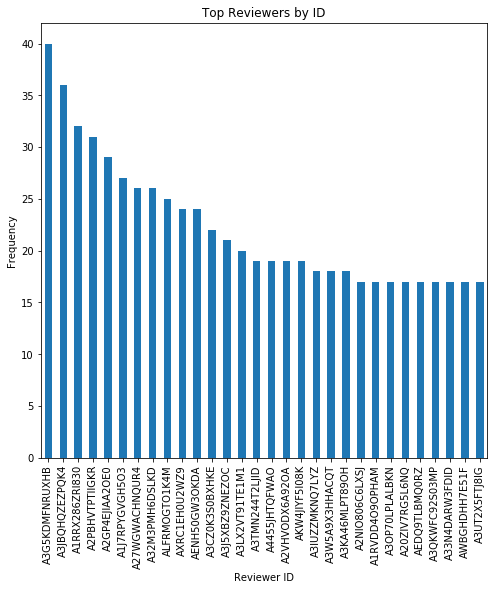

In [35]:
plt.figure(figsize = (8, 8))
plt.title("Top Reviewers by ID")
plt.xlabel('Reviewer ID')
plt.xticks(rotation= 90)
plt.ylabel('Frequency')
df['reviewerID'].value_counts()[:30].plot(kind = 'bar');

In [76]:
df['asin'].value_counts()[:20]

B000V0IBDM    4384
B000KPIHQ4    4375
B00I0VHS10    3889
B00RLSCLJM    3638
B000PHANNM    2572
B000YFSR5G    2538
B00201ER88    2206
B00GXE331K    2027
B000P0X15G    1928
B00XT15P8E    1855
B0017U1KBK    1828
B005N7YWX6    1688
B004HX6P1E    1680
B000YFSR4W    1650
B009RUKQ2G    1592
B000JOOR7O    1588
B00ZW3SCF0    1541
B000GHRZN2    1418
B000GHMRLW    1418
B00XTM0ZPG    1408
Name: asin, dtype: int64

In [74]:
what_is_its = (product_df['asin'] == 'B000P0X15G')
product_df[what_is_its]

,title,image,brand,feature,rank,date,asin,description,price,also_view,also_buy,fit,details,similar_item,tech1
3315,"i play. Girls' Baby Brim Sun Protection Hat, A...",[https://images-na.ssl-images-amazon.com/image...,i play.,[Shipping Information:\n \n...,,5 star5 star (0%),B000P0X15G,,$7.99 - $18.38,,,"class=""a-normal a-align-center a-spacing-smal...",,,


Using the `asin` through the Product DataFrame, these are the 20 items with the most reviews. 

|`asin` |Number of Reviews| Product Name |
|---|---|---|
|B000V0IBDM| 4383 |Powerstep Pinnacle Orthotic Shoe Insoles|
|B000KPIHQ4|4375 |Powerstep Pinnacle Orthotic Shoe Insoles |
|B00I0VHS10|3889|90 Degree By Reflex Power Flex Yoga Capri | 
|B00RLSCLJM|3638|MJ Metals Jewelry 2mm to 10mm White Tungsten Carbide Mirror Polished Classic Wedding Ring | 
|B000PHANNM|2572 |i play. Baby Boys Flap Sun Protection Hat|
|B000YFSR5G|2538 |Hanes Mens EcoSmart Fleece Sweatpant|
|B00201ER88|2206|i play. by green sprouts Baby & Toddler Brim Sun Protection Hat |
|B00GXE331K|2027|Best RFID Blocking Card Holder Case for Men|
|B000P0X15G|1928|i play. Girls' Baby Brim Sun Protection Hat|
|B00XT15P8E|1855|Marino Avenue Men’s Genuine Leather Ratchet Dress Belt|
|B0017U1KBK|1828|Totes Kids Bubble Umbrella|
|B005N7YWX6|1688|Ingrid & Isabel Women's Maternity Everyday Bellaband|
|B004HX6P1E|1680|BodyJ4You 50PC Tongue Barbells Nipple Rings 14G Mix Acrylic Ball Steel Flexible Piercing Jewelry|
|B000YFSR4W|1650|Hanes Mens EcoSmart Fleece Sweatpant|
|B009RUKQ2G|1592|Scarleton Large Satchel H106801 - Black|
|B000JOOR7O|1588|Vans Adult Classic Slip-On, (Checkerboard)|
|B00ZW3SCF0|1541|Womens Crop Top Midi Skirt Outfit Two Piece Bodycon Bandage Dress|
|B000GHRZN2|1418|Carhartt Men's Loose Fit Five Pocket Canvas Carpenter Jean|
|B000GHMRLW|1418|Carhartt Men's Loose Fit Five Pocket CanvasCarpenter Jean|
|B00XTM0ZPG|1408|WearMe Pro - Classic Half Frame Polarized Sunglasses|

From examining the most frequently occuring `asin` we can see there is both Men's, Women's and Children's clothing products listed under the umbrella of Amazon Fashion. The dataset also includes items that are a little more broad, including shoe insoles, accessories, etc. 

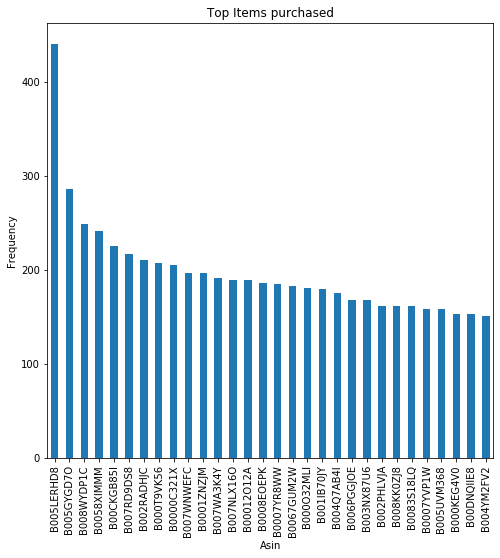

In [35]:
plt.figure(figsize = (8, 8))
plt.title("Top Items purchased")
plt.xlabel('Asin')
plt.xticks(rotation= 90)
plt.ylabel('Frequency')
data['asin'].value_counts()[:30].plot(kind = 'bar');

In [29]:
data['overall'].value_counts()

5.0    163240
4.0     58357
3.0     30425
2.0     15463
1.0     11192
Name: overall, dtype: int64

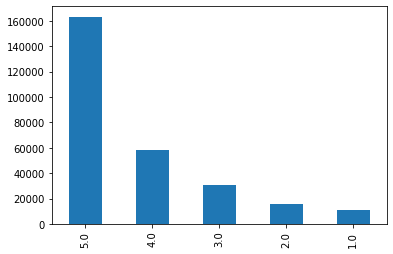

In [7]:
data['overall'].value_counts().plot(kind = 'bar')

In [30]:
data['helpful'].value_counts()

[0, 0]        191656
[1, 1]         29726
[0, 1]          9721
[2, 2]          9026
[1, 2]          6516
               ...  
[134, 135]         1
[74, 78]           1
[131, 135]         1
[154, 154]         1
[123, 127]         1
Name: helpful, Length: 974, dtype: int64

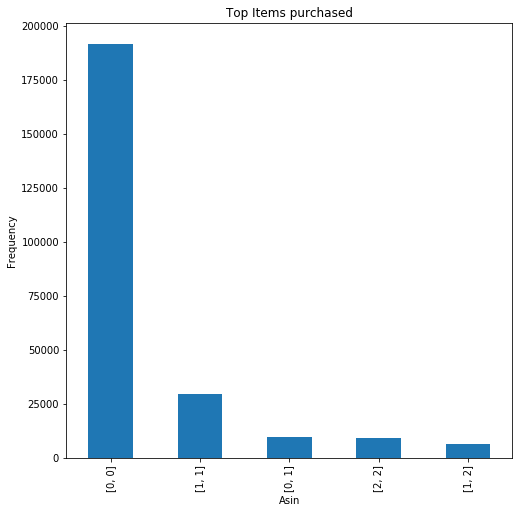

In [9]:
plt.figure(figsize = (8, 8))
plt.title("Top Items purchased")
plt.xlabel('Asin')
plt.xticks(rotation= 90)
plt.ylabel('Frequency')
data['helpful'].value_counts()[:5].plot(kind = 'bar');

In [6]:
data['reviewTime'].sort_values()

25120     01 1, 2008
41100     01 1, 2008
30182     01 1, 2008
29521     01 1, 2009
57050     01 1, 2010
             ...    
243368    12 9, 2013
222514    12 9, 2013
59073     12 9, 2013
274362    12 9, 2013
180302    12 9, 2013
Name: reviewTime, Length: 278677, dtype: object

In [32]:
data['reviewTime'].value_counts()

12 26, 2013    918
12 31, 2013    827
01 8, 2014     803
01 2, 2014     796
01 9, 2014     796
              ... 
06 17, 2008      1
03 5, 2007       1
06 14, 2006      1
08 11, 2008      1
08 2, 2007       1
Name: reviewTime, Length: 2691, dtype: int64

**Oberservation:** Interestingly enough, most of the reviews in this dataset are left the day after Christmas 2013, followed then by New Years Eve of the same year. 

We can also see that reviews from this dataset span the from Jan 1 , 2008 to December 9, 2013. 

## Data Processing 

From here let's move into processing the data for modeling. 

## Sources 

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=LgWrDtZ94w89

https://stylecaster.com/amazon-fashion-the-drop-by-you-february-2020/ Bella Gerard 

https://www.latimes.com/entertainment-arts/business/story/2020-02-22/amazon-making-the-cut-reality-tv-heidi-klum-prime
Wendy Lee, Feb 22 2020